# IE 582 Homework 1 - FALL'24

#### Berat Kubilay Güngez - 2021402087

### Table of Contents

1. [Introduction](#introduction)
2. [Library and Data Imports](#import)
3. [Implied Probability Calculation and Analysis](#prob)
4. [Noisy Data Analysis](#noisy)
5. [Decision Tree Model](#tree)
6. [Conclusion](#conclusion)

### Introduction <a name="introduction"></a>

This homework assignment explores the application of statistical and basic machine learning techniques in the context of sports betting, with a particular focus on predicting football match outcomes. The primary objective is to assess the relationship between betting odds, implied probabilities, and actual match results by using a decision tree model for prediction. The project involves calculating implied probabilities from betting odds, cleaning the data by removing events create noise, and comparing the implied probabilities to the results generated by the decision tree model.

### Library and Data Imports <a name="import"></a>

In [472]:
import pandas as pd # data importing and manipulation 
import matplotlib.pyplot as plt # data visualization
import numpy as np # linear algebra and math functions
from sklearn.tree import DecisionTreeClassifier, plot_tree # decision tree classifier
from sklearn.metrics import accuracy_score # accuracy score

The first step in the analysis is importing the data from the provided CSV file. Any missing values (NaN) in the dataset are replaced with zeros. Given the size of the dataset, this approach is considered appropriate, as it ensures that the model can handle the data without issues related to missing values, and the impact of replacing NaN values with zeros is minimal in this context.

In [ ]:
data_loc = "match data/data"
df = pd.read_csv(data_loc)
df.fillna(0, inplace=True) # fill NaN values with 0

df.head(10)

,fixture_id,halftime,current_time,half_start_datetime,match_start_datetime,minute,second,latest_bookmaker_update,suspended,stopped,...,Throwins - home,Total Crosses - away,Total Crosses - home,Yellowcards - away,Yellowcards - home,Yellowred Cards - away,Yellowred Cards - home,current_state,final_score,result
0,19172016.0,1st-half,2024-08-09 18:11:36,2024-08-09 18:01:37,2024-08-09 18:01:37,9,59,2024-08-09 18:11:28,False,False,...,1.0,0.0,3.0,0.0,0.0,0.0,0.0,X,2-1,1
1,19172016.0,1st-half,2024-08-09 18:27:30,2024-08-09 18:01:37,2024-08-09 18:01:37,25,53,2024-08-09 18:27:24,False,False,...,11.0,1.0,12.0,0.0,0.0,0.0,0.0,X,2-1,1
2,19172016.0,1st-half,2024-08-09 18:28:25,2024-08-09 18:01:37,2024-08-09 18:01:37,26,48,2024-08-09 18:28:20,False,False,...,11.0,1.0,13.0,0.0,0.0,0.0,0.0,X,2-1,1
3,19172016.0,1st-half,2024-08-09 18:29:32,2024-08-09 18:01:37,2024-08-09 18:01:37,27,55,2024-08-09 18:29:28,False,False,...,11.0,1.0,13.0,0.0,0.0,0.0,0.0,X,2-1,1
4,19172016.0,1st-half,2024-08-09 18:30:37,2024-08-09 18:01:37,2024-08-09 18:01:37,29,0,2024-08-09 18:30:32,True,False,...,11.0,1.0,14.0,0.0,0.0,0.0,0.0,X,2-1,1
5,19172016.0,1st-half,2024-08-09 18:31:18,2024-08-09 18:01:37,2024-08-09 18:01:37,29,41,2024-08-09 18:31:17,True,False,...,11.0,1.0,14.0,0.0,0.0,0.0,0.0,X,2-1,1
6,19172016.0,1st-half,2024-08-09 18:32:24,2024-08-09 18:01:37,2024-08-09 18:01:37,30,47,2024-08-09 18:32:22,True,False,...,11.0,1.0,14.0,0.0,0.0,0.0,0.0,X,2-1,1
7,19172016.0,1st-half,2024-08-09 18:33:27,2024-08-09 18:01:37,2024-08-09 18:01:37,31,50,2024-08-09 18:33:21,True,False,...,11.0,1.0,14.0,0.0,0.0,0.0,0.0,X,2-1,1
8,19172016.0,1st-half,2024-08-09 18:34:18,2024-08-09 18:01:37,2024-08-09 18:01:37,32,41,2024-08-09 18:34:12,False,False,...,11.0,1.0,14.0,0.0,0.0,0.0,0.0,X,2-1,1
9,19172016.0,1st-half,2024-08-09 18:35:27,2024-08-09 18:01:37,2024-08-09 18:01:37,33,50,2024-08-09 18:35:26,False,False,...,11.0,1.0,15.0,0.0,0.0,0.0,0.0,X,2-1,1


Suspended and stopped matches are dropped from the dataset, as they do not provide meaningful information for the analysis. This was given in the homework description. In total, approx. 12% of the data is dropped due to this reason.

In [ ]:
print(f"Before suspended or stopped games are dropped: {len(df)}")

columns_to_check = [
    "suspended",
    "stopped"]

mask = (df[columns_to_check] == False).all(axis=1) # mask for rows where all columns are False

df = df[mask] 
print(f"After suspended or stopped games are dropped: {len(df)}")

Before suspended or stopped games are dropped: 63944
After suspended or stopped games are dropped: 56127


### Implied Probability Calculation and Analysis <a name="prob"></a>

In the sports betting context;
- "1" represents the amount of money that can be won by betting 1 unit on the home team
- "X" represents the amount of money that can be won by betting 1 unit on a draw
- "2" represents the amount of money that can be won by betting 1 unit on the away team

In [ ]:
df_odds = df.copy()

results = df_odds['result'] # save the results column
half = df_odds['halftime'] # save the halftime column
df_odds = df_odds.loc[:, "1":"X"]

df_odds.head()

,1,2,X
0,1.22,10.0,6.5
1,1.20,13.0,6.0
2,1.20,13.0,6.0
3,1.20,13.0,6.0
8,1.20,15.0,6.0


The implied probability of an event is calculated as the inverse of the odds for that event. For example, if the odds for the home team winning are 2.0, the implied probability is 1/2.0 = 0.5. This calculation is performed for all events in the dataset to determine the implied probabilities for each outcome. Also, note that these probabilities sum up more than 1, which is expected as bookmakers add a margin to the odds to ensure profitability. Therefore, the implied probabilities are normalized to sum up to 1.

In [ ]:
prob_df = 1 / df_odds # calculate the probability of each outcome
prob_df.columns = ["Pr{Home Win}", "Pr{Away Win}", "Pr{Draw}"]

normalized_prob_df = prob_df.div(prob_df.sum(axis=1), axis=0) # normalize the probabilities

prob_df["Result"] = results
prob_df["Half"] = half
normalized_prob_df["Result"] = results
normalized_prob_df["Half"] = half

prob_df.head()

,Pr{Home Win},Pr{Away Win},Pr{Draw},Result,Half
0,0.819672,0.100000,0.153846,1,1st-half
1,0.833333,0.076923,0.166667,1,1st-half
2,0.833333,0.076923,0.166667,1,1st-half
3,0.833333,0.076923,0.166667,1,1st-half
8,0.833333,0.066667,0.166667,1,1st-half


In [447]:
normalized_prob_df.head()

,Pr{Home Win},Pr{Away Win},Pr{Draw},Result,Half
0,0.763538,0.093152,0.143310,1,1st-half
1,0.773810,0.071429,0.154762,1,1st-half
2,0.773810,0.071429,0.154762,1,1st-half
3,0.773810,0.071429,0.154762,1,1st-half
8,0.781250,0.062500,0.156250,1,1st-half


In [ ]:
bins = [-1, -0.75, -0.5, -0.25, 0, 0.25, 0.5, 0.75, 1] # define the bins for the histogram

prob_df["Pr{Home Win} - Pr{Away Win}"] = prob_df["Pr{Home Win}"] - prob_df["Pr{Away Win}"]
prob_df["Bin"] = pd.cut(prob_df["Pr{Home Win} - Pr{Away Win}"], bins)

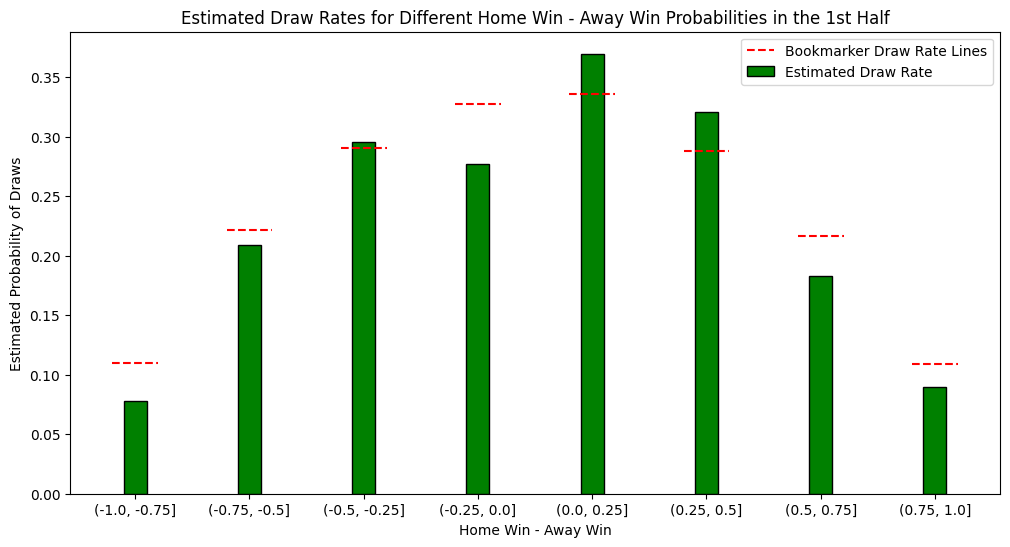

In [449]:
first_half_prob_df = prob_df[prob_df["Half"] == "1st-half"]

bin_totals = first_half_prob_df.groupby("Bin", observed=False).size()
bin_draws = first_half_prob_df[first_half_prob_df["Result"] == "X"].groupby("Bin", observed=False).size()

estimated_draws = bin_draws / bin_totals

bookmarker_draws = first_half_prob_df.groupby("Bin", observed=False)["Pr{Draw}"].mean()

plt.figure(figsize=(12, 6))

plt.bar(bin_totals.index.astype(str), estimated_draws , width=0.2, align="center", edgecolor = "black", color = "green", label="Estimated Draw Rate")
plt.hlines(
    y=bookmarker_draws,                  
    xmin=-0.2 + np.arange(len(bookmarker_draws)),  
    xmax=0.2 + np.arange(len(bookmarker_draws)),  
    colors="red",
    linestyles="--",
    label="Bookmarker Draw Rate Lines")

plt.legend(loc="upper right")
plt.xlabel("Home Win - Away Win")
plt.ylabel("Estimated Probability of Draws")
plt.title("Estimated Draw Rates for Different Home Win - Away Win Probabilities in the 1st Half")

plt.show()

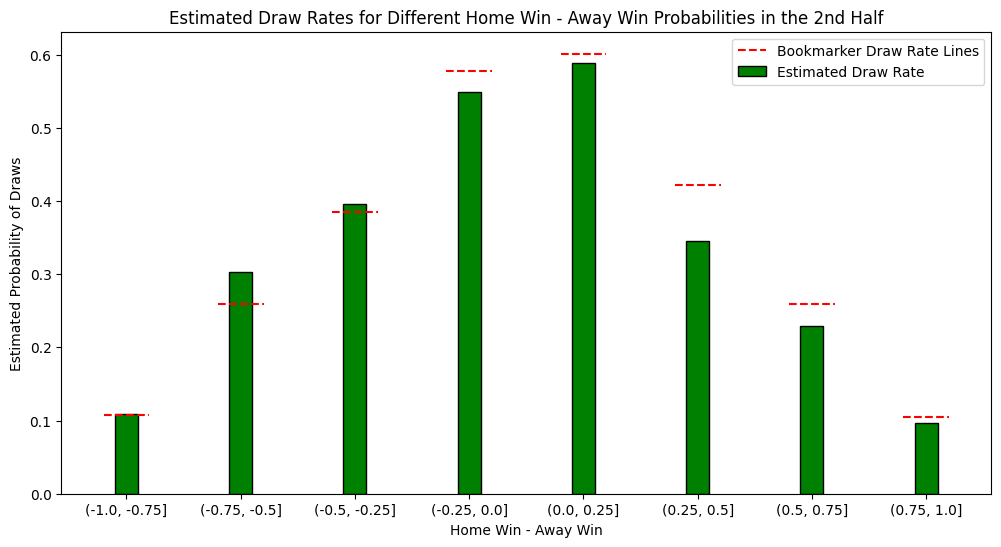

In [450]:
second_half_prob_df = prob_df[prob_df["Half"] == "2nd-half"]

bin_totals = second_half_prob_df.groupby("Bin", observed=False).size()
bin_draws = second_half_prob_df[second_half_prob_df["Result"] == "X"].groupby("Bin", observed=False).size()

estimated_draws = bin_draws / bin_totals

bookmarker_draws = second_half_prob_df.groupby("Bin", observed=False)["Pr{Draw}"].mean()

plt.figure(figsize=(12, 6))

plt.bar(bin_totals.index.astype(str), estimated_draws , width=0.2, align="center", edgecolor = "black", color = "green", label="Estimated Draw Rate")
plt.hlines(
    y=bookmarker_draws,                  
    xmin=-0.2 + np.arange(len(bookmarker_draws)),  
    xmax=0.2 + np.arange(len(bookmarker_draws)),  
    colors="red",
    linestyles="--",
    label="Bookmarker Draw Rate Lines")

plt.legend(loc="upper right")
plt.xlabel("Home Win - Away Win")
plt.ylabel("Estimated Probability of Draws")
plt.title("Estimated Draw Rates for Different Home Win - Away Win Probabilities in the 2nd Half")

plt.show()

In [451]:
normalized_prob_df["Pr{Home Win} - Pr{Away Win}"] = normalized_prob_df["Pr{Home Win}"] - normalized_prob_df["Pr{Away Win}"]
normalized_prob_df["Bin"] = pd.cut(normalized_prob_df["Pr{Home Win} - Pr{Away Win}"], bins)

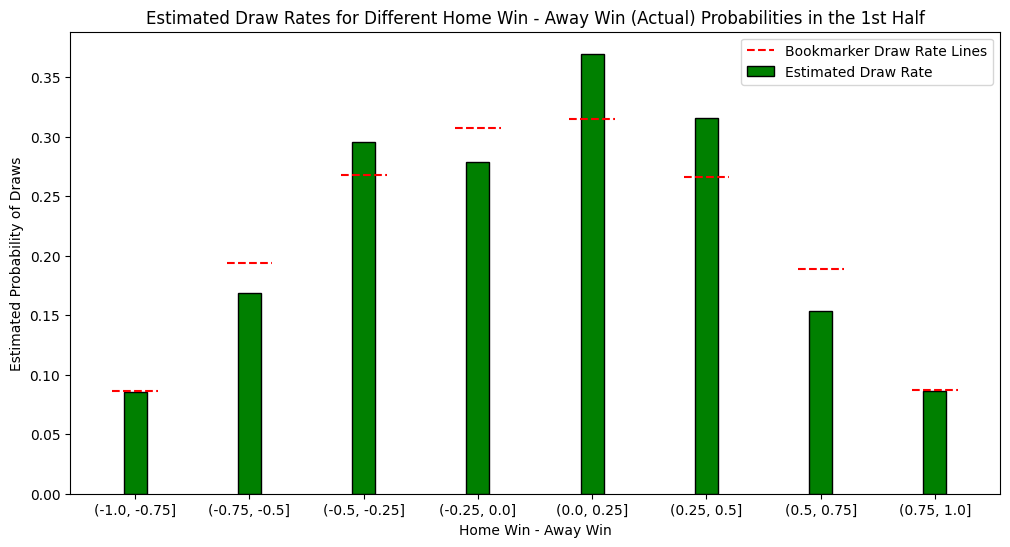

In [452]:
first_half_normalized_prob_df = normalized_prob_df[normalized_prob_df["Half"] == "1st-half"]

bin_totals = first_half_normalized_prob_df.groupby("Bin", observed=False).size()
bin_draws = first_half_normalized_prob_df[first_half_normalized_prob_df["Result"] == "X"].groupby("Bin", observed=False).size()

estimated_draws = bin_draws / bin_totals

bookmarker_draws = first_half_normalized_prob_df.groupby("Bin", observed=False)["Pr{Draw}"].mean()

plt.figure(figsize=(12, 6))

plt.bar(bin_totals.index.astype(str), estimated_draws , width=0.2, align="center", edgecolor = "black", color = "green", label="Estimated Draw Rate")
plt.hlines(
    y=bookmarker_draws,                  
    xmin=-0.2 + np.arange(len(bookmarker_draws)),  
    xmax=0.2 + np.arange(len(bookmarker_draws)),  
    colors="red",
    linestyles="--",
    label="Bookmarker Draw Rate Lines")

plt.legend(loc="upper right")
plt.xlabel("Home Win - Away Win")
plt.ylabel("Estimated Probability of Draws")
plt.title("Estimated Draw Rates for Different Home Win - Away Win (Actual) Probabilities in the 1st Half")

plt.show()

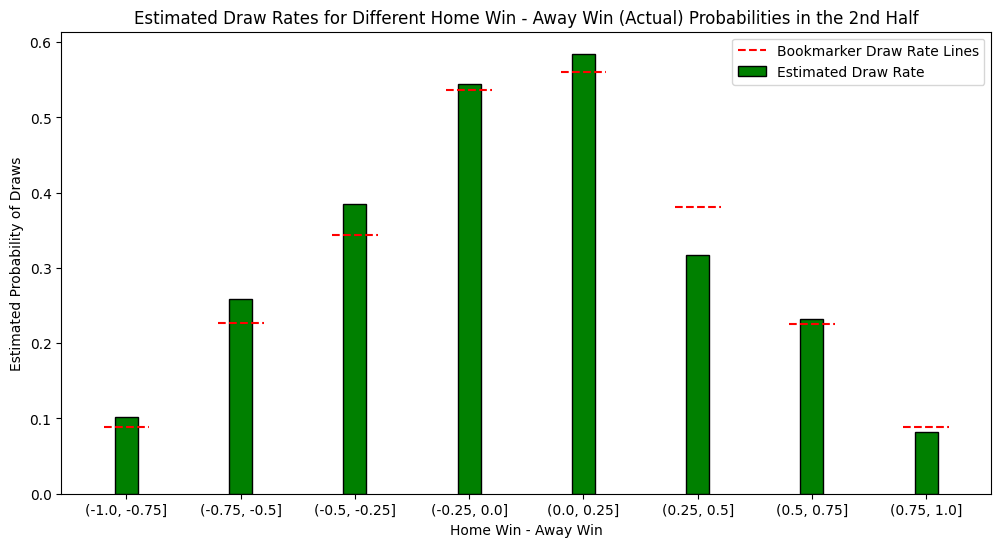

In [453]:
second_half_normalized_prob_df = normalized_prob_df[normalized_prob_df["Half"] == "2nd-half"]

bin_totals = second_half_normalized_prob_df.groupby("Bin", observed=False).size()
bin_draws = second_half_normalized_prob_df[second_half_normalized_prob_df["Result"] == "X"].groupby("Bin", observed=False).size()

estimated_draws = bin_draws / bin_totals

bookmarker_draws = second_half_normalized_prob_df.groupby("Bin", observed=False)["Pr{Draw}"].mean()

plt.figure(figsize=(12, 6))

plt.bar(bin_totals.index.astype(str), estimated_draws , width=0.2, align="center", edgecolor = "black", color = "green", label="Estimated Draw Rate")
plt.hlines(
    y=bookmarker_draws,                  
    xmin=-0.2 + np.arange(len(bookmarker_draws)),  
    xmax=0.2 + np.arange(len(bookmarker_draws)),  
    colors="red",
    linestyles="--",
    label="Bookmarker Draw Rate Lines")

plt.legend(loc="upper right")
plt.xlabel("Home Win - Away Win")
plt.ylabel("Estimated Probability of Draws")
plt.title("Estimated Draw Rates for Different Home Win - Away Win (Actual) Probabilities in the 2nd Half")

plt.show()

### Noisy Data Analysis <a name="noisy"></a>

In [454]:
df["Goal_in_first_10_mins"] = df.apply(
    lambda row: True if row["halftime"] == "1st-half" and row["minute"] < 10 and (row["Goals - home"] + row["Goals - away"] >= 1) 
    else False,
    axis=1)

columns_to_keep = ["fixture_id", "halftime", "minute", "Goals - away", "Goals - home"]
matches = df.copy()
matches = matches[columns_to_keep]
matches["Total Goals"] = matches["Goals - away"] + matches["Goals - home"]
matches = matches[(matches["minute"] < 40) & (matches["halftime"] == "2nd-half")]
matches = matches.loc[matches.groupby("fixture_id")["Total Goals"].idxmax()]
matches.drop(columns=["Goals - away", "Goals - home", "halftime", "minute"], inplace=True)
df["Goal_after_80_mins"] = df.apply(
    lambda row: True if row["minute"] >= 40 and row["halftime"] == "2nd-half" and
    (row["Goals - home"] + row["Goals - away"]) > matches[matches["fixture_id"] == row["fixture_id"]]["Total Goals"].values[0] 
    else False,
    axis=1)

df["Redcard_in_first_15_mins"] = df.apply(
    lambda row: True if (row["halftime"] == "1st-half" and row["minute"] < 15) 
    and (row["Redcards - home"] + row["Redcards - away"] + row["Yellowred Cards - home"] + row["Yellowred Cards - away"] >= 1) 
    else False,
    axis=1)

columns_to_keep = ["fixture_id", "halftime", "minute", "Redcards - away", "Redcards - home", "Yellowred Cards - away", "Yellowred Cards - home"]
matches = df.copy()
matches = matches[columns_to_keep]
matches["Total Red Cards"] = matches["Redcards - away"] + matches["Redcards - home"] + matches["Yellowred Cards - away"] + matches["Yellowred Cards - home"]
matches = matches[(matches["minute"] < 35) & (matches["halftime"] == "2nd-half")]
matches = matches.loc[matches.groupby("fixture_id")["Total Red Cards"].idxmax()]
matches.drop(columns=["Redcards - away", "Redcards - home", "Yellowred Cards - away", "Yellowred Cards - home" ,"halftime", "minute"], inplace=True)
df["Red_cards_after_75_mins"] = df.apply(
    lambda row: True if row["minute"] >= 35 and row["halftime"] == "2nd-half" and
    (row["Redcards - home"] + row["Redcards - away"] + row["Yellowred Cards - away"] + row["Yellowred Cards - home"]) > matches[matches["fixture_id"] == row["fixture_id"]]["Total Red Cards"].values[0] 
    else False,
    axis=1)

df["Yellowcard_in_first_10_mins"] = df.apply(
    lambda row: True if row["halftime"] == "1st-half" and row["minute"] < 10 and (row["Yellowcards - home"] + row["Yellowcards - away"] >= 1)
    else False,
    axis=1)

df["Injuries_in_first_30_mins"] = df.apply(
    lambda row: True if (row["halftime"] == "1st-half") and row["minute"] < 30 and (row["Injuries - home"] + row["Injuries - away"] >= 1) 
    else False,
    axis=1)

columns_to_keep = ["fixture_id", "halftime", "minute", "Injuries - away", "Injuries - home"]
matches = df.copy()
matches = matches[columns_to_keep]
matches["Total Injuries"] = matches["Injuries - away"] + matches["Injuries - home"]
matches = matches[(matches["minute"] < 40) & (matches["halftime"] == "2nd-half")]
matches = matches.loc[matches.groupby("fixture_id")["Total Injuries"].idxmax()]
matches.drop(columns=["Injuries - away", "Injuries - home", "halftime", "minute"], inplace=True)
df["Injuries_after_80_mins"] = df.apply(
    lambda row: True if row["minute"] >= 40 and row["halftime"] == "2nd-half" and
    (row["Injuries - home"] + row["Injuries - away"]) > matches[matches["fixture_id"] == row["fixture_id"]]["Total Injuries"].values[0] 
    else False,
    axis=1)

df["Substutions_in_first_30_mins"] = df.apply(
    lambda row: True if row["halftime"] == "1st-half" and row["minute"] < 30 and (row["Substitutions - home"] + row["Substitutions - away"] >= 1) 
    else False,
    axis=1)

In [455]:
print(f"Number of matches with a goal before 10 minutes: {df['Goal_in_first_10_mins'].sum()}")
print(f"Number of matches with a goal after 80 minutes: {df['Goal_after_80_mins'].sum()}")
print(f"Number of matches with a red card before 15 minutes: {df['Redcard_in_first_15_mins'].sum()}")
print(f"Number of matches with a red card after 75 minutes: {df['Red_cards_after_75_mins'].sum()}")
print(f"Number of matches with a yellow card before 10 minutes: {df['Yellowcard_in_first_10_mins'].sum()}")
print(f"Number of matches with an injury before 30 minutes: {df['Injuries_in_first_30_mins'].sum()}")
print(f"Number of matches with an injury after 80 minutes: {df['Injuries_after_80_mins'].sum()}")
print(f"Number of matches with a substitutions before 30 minutes: {df['Substutions_in_first_30_mins'].sum()}")

Number of matches with a goal before 10 minutes: 512
Number of matches with a goal after 80 minutes: 576
Number of matches with a red card before 15 minutes: 11
Number of matches with a red card after 75 minutes: 306
Number of matches with a yellow card before 10 minutes: 196
Number of matches with an injury before 30 minutes: 490
Number of matches with an injury after 80 minutes: 289
Number of matches with a substitutions before 30 minutes: 784


In [456]:
print(f"Current number of rows: {len(df)}")
a = len(df)

columns_to_check = [
    "Goal_in_first_10_mins",
    "Redcard_in_first_15_mins",
    "Yellowcard_in_first_10_mins",
    "Injuries_in_first_30_mins",
    "Goal_after_80_mins",
    "Substutions_in_first_30_mins",
    "Red_cards_after_75_mins",
    "Injuries_after_80_mins"
]

mask = (df[columns_to_check] == False).all(axis=1)

df = df[mask]

df = df.drop(columns=columns_to_check)

print(f"Number of rows after removing matches with events: {len(df)}")
print(f"Difference in number of rows: {a - len(df)}")

Current number of rows: 56127
Number of rows after removing matches with events: 53177
Difference in number of rows: 2950


In [457]:
df_odds = df.copy()
results = df_odds['result']
half = df_odds['halftime']
df_odds = df_odds.loc[:, "1":"X"]

prob_df = 1 / df_odds
prob_df.columns = ["Pr{Home Win}", "Pr{Away Win}", "Pr{Draw}"]

normalized_prob_df = prob_df.div(prob_df.sum(axis=1), axis=0)

prob_df["Result"] = results
prob_df["Half"] = half
normalized_prob_df["Result"] = results
normalized_prob_df["Half"] = half

In [458]:
prob_df["Pr{Home Win} - Pr{Away Win}"] = prob_df["Pr{Home Win}"] - prob_df["Pr{Away Win}"]
prob_df["Bin"] = pd.cut(prob_df["Pr{Home Win} - Pr{Away Win}"], bins)

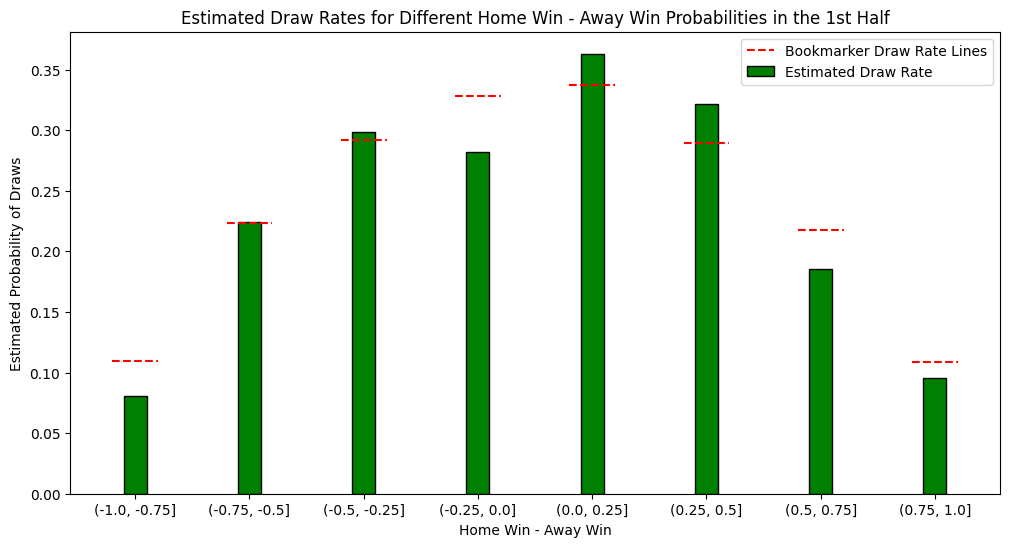

In [459]:
first_half_prob_df = prob_df[prob_df["Half"] == "1st-half"]

bin_totals = first_half_prob_df.groupby("Bin", observed=False).size()
bin_draws = first_half_prob_df[first_half_prob_df["Result"] == "X"].groupby("Bin", observed=False).size()

estimated_draws = bin_draws / bin_totals

bookmarker_draws = first_half_prob_df.groupby("Bin", observed=False)["Pr{Draw}"].mean()

plt.figure(figsize=(12, 6))

plt.bar(bin_totals.index.astype(str), estimated_draws , width=0.2, align="center", edgecolor = "black", color = "green", label="Estimated Draw Rate")
plt.hlines(
    y=bookmarker_draws,                  
    xmin=-0.2 + np.arange(len(bookmarker_draws)),  
    xmax=0.2 + np.arange(len(bookmarker_draws)),  
    colors="red",
    linestyles="--",
    label="Bookmarker Draw Rate Lines")

plt.legend(loc="upper right")
plt.xlabel("Home Win - Away Win")
plt.ylabel("Estimated Probability of Draws")
plt.title("Estimated Draw Rates for Different Home Win - Away Win Probabilities in the 1st Half")

plt.show()

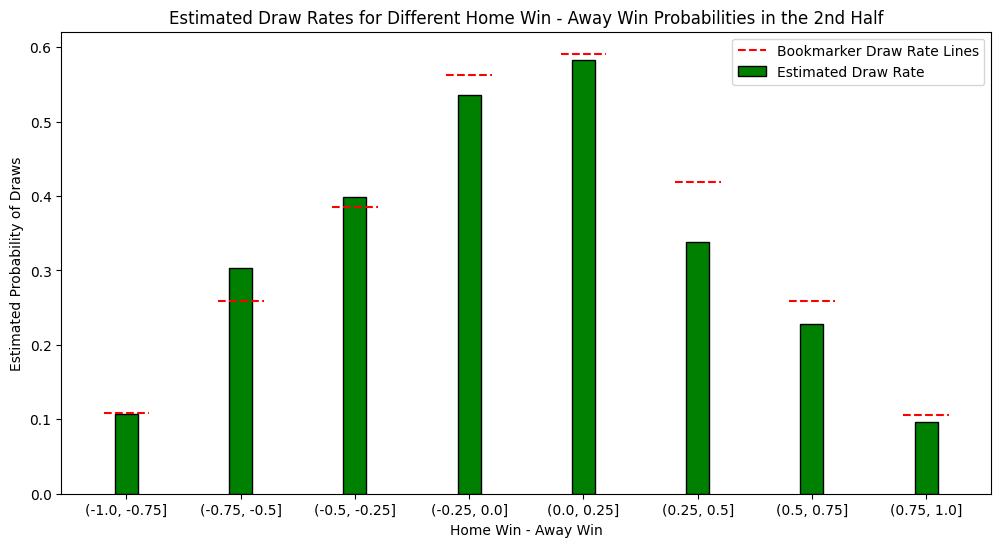

In [460]:
second_half_prob_df = prob_df[prob_df["Half"] == "2nd-half"]

bin_totals = second_half_prob_df.groupby("Bin", observed=False).size()
bin_draws = second_half_prob_df[second_half_prob_df["Result"] == "X"].groupby("Bin", observed=False).size()

estimated_draws = bin_draws / bin_totals

bookmarker_draws = second_half_prob_df.groupby("Bin", observed=False)["Pr{Draw}"].mean()

plt.figure(figsize=(12, 6))

plt.bar(bin_totals.index.astype(str), estimated_draws , width=0.2, align="center", edgecolor = "black", color = "green", label="Estimated Draw Rate")
plt.hlines(
    y=bookmarker_draws,                  
    xmin=-0.2 + np.arange(len(bookmarker_draws)),  
    xmax=0.2 + np.arange(len(bookmarker_draws)),  
    colors="red",
    linestyles="--",
    label="Bookmarker Draw Rate Lines")

plt.legend(loc="upper right")
plt.xlabel("Home Win - Away Win")
plt.ylabel("Estimated Probability of Draws")
plt.title("Estimated Draw Rates for Different Home Win - Away Win Probabilities in the 2nd Half")

plt.show()

In [461]:
normalized_prob_df["Pr{Home Win} - Pr{Away Win}"] = normalized_prob_df["Pr{Home Win}"] - normalized_prob_df["Pr{Away Win}"]
normalized_prob_df["Bin"] = pd.cut(normalized_prob_df["Pr{Home Win} - Pr{Away Win}"], bins)

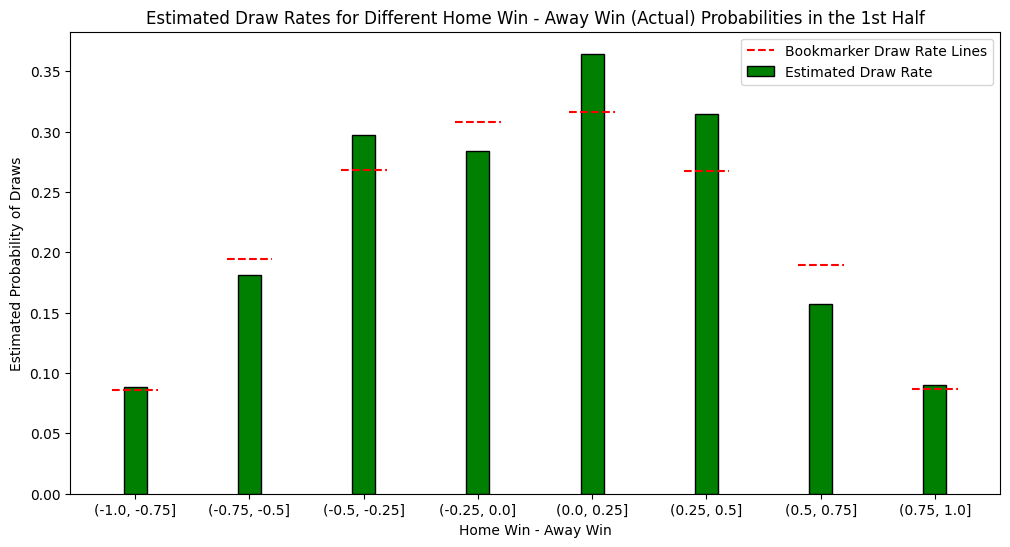

In [462]:
first_half_normalized_prob_df = normalized_prob_df[normalized_prob_df["Half"] == "1st-half"]

bin_totals = first_half_normalized_prob_df.groupby("Bin", observed=False).size()
bin_draws = first_half_normalized_prob_df[first_half_normalized_prob_df["Result"] == "X"].groupby("Bin", observed=False).size()

estimated_draws = bin_draws / bin_totals

bookmarker_draws = first_half_normalized_prob_df.groupby("Bin", observed=False)["Pr{Draw}"].mean()

plt.figure(figsize=(12, 6))

plt.bar(bin_totals.index.astype(str), estimated_draws , width=0.2, align="center", edgecolor = "black", color = "green", label="Estimated Draw Rate")
plt.hlines(
    y=bookmarker_draws,                  
    xmin=-0.2 + np.arange(len(bookmarker_draws)),  
    xmax=0.2 + np.arange(len(bookmarker_draws)),  
    colors="red",
    linestyles="--",
    label="Bookmarker Draw Rate Lines")

plt.legend(loc="upper right")
plt.xlabel("Home Win - Away Win")
plt.ylabel("Estimated Probability of Draws")
plt.title("Estimated Draw Rates for Different Home Win - Away Win (Actual) Probabilities in the 1st Half")

plt.show()

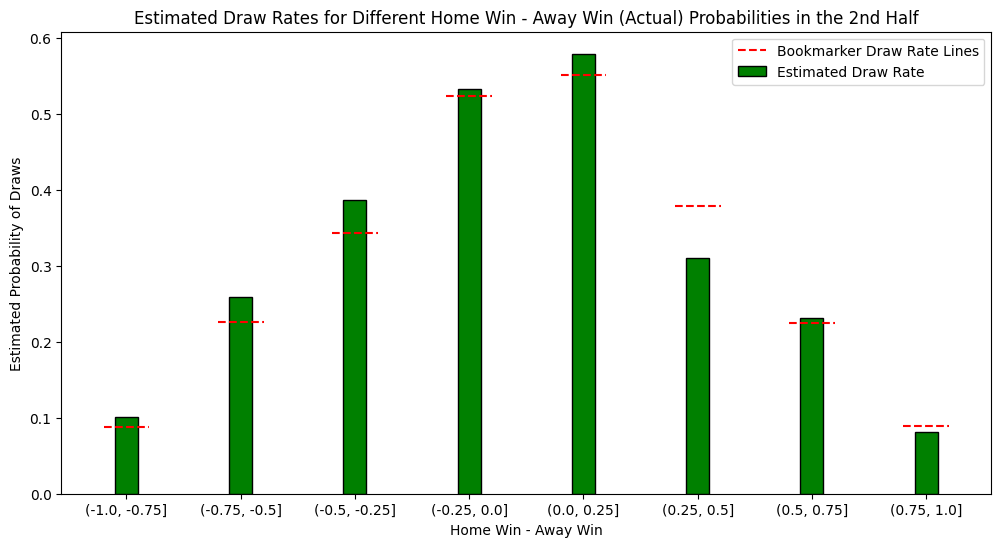

In [463]:
second_half_normalized_prob_df = normalized_prob_df[normalized_prob_df["Half"] == "2nd-half"]

bin_totals = second_half_normalized_prob_df.groupby("Bin", observed=False).size()
bin_draws = second_half_normalized_prob_df[second_half_normalized_prob_df["Result"] == "X"].groupby("Bin", observed=False).size()

estimated_draws = bin_draws / bin_totals

bookmarker_draws = second_half_normalized_prob_df.groupby("Bin", observed=False)["Pr{Draw}"].mean()

plt.figure(figsize=(12, 6))

plt.bar(bin_totals.index.astype(str), estimated_draws , width=0.2, align="center", edgecolor = "black", color = "green", label="Estimated Draw Rate")
plt.hlines(
    y=bookmarker_draws,                  
    xmin=-0.2 + np.arange(len(bookmarker_draws)),  
    xmax=0.2 + np.arange(len(bookmarker_draws)),  
    colors="red",
    linestyles="--",
    label="Bookmarker Draw Rate Lines")

plt.legend(loc="upper right")
plt.xlabel("Home Win - Away Win")
plt.ylabel("Estimated Probability of Draws")
plt.title("Estimated Draw Rates for Different Home Win - Away Win (Actual) Probabilities in the 2nd Half")

plt.show()

### Decision Tree Model <a name="tree"></a>

In [464]:
target = [1 if result == "1" else 2 if result == "2" else 0 for result in df["result"]]

In [465]:
feature_df = df.copy()
feature_df.drop(columns=["result", "fixture_id", "current_time", "half_start_datetime", "match_start_datetime", "latest_bookmaker_update", 
                        "suspended", "stopped", "1", "2", "X", "final_score", "Assists - away", "Assists - home", "name", "second", "ticking",
                        "Penalties - home", "Penalties - away"], inplace=True)

feature_df["minute"] = feature_df["minute"].astype(float)
feature_df["halftime"] = [1.0 if half == "1st-half" else 2.0 for half in feature_df["halftime"]]
feature_df["current_state"] = [1.0 if result == "1" else 2.0 if result == "2" else 0 for result in feature_df["current_state"]]
feature_df["Total Goals"] = feature_df["Goals - away"] + feature_df["Goals - home"]
feature_df["Goal Difference"] = feature_df["Goals - home"] - feature_df["Goals - away"]
feature_df["Dangerous Attacks Difference"] = feature_df["Dangerous Attacks - home"] - feature_df["Dangerous Attacks - away"]
feature_df["Ball Possession % Difference"] = feature_df["Ball Possession % - home"] - feature_df["Ball Possession % - away"]
feature_df["Goal Attempts Difference"] = feature_df["Goal Attempts - home"] - feature_df["Goal Attempts - away"]

feature_df

,halftime,minute,Accurate Crosses - away,Accurate Crosses - home,Attacks - away,Attacks - home,Ball Possession % - away,Ball Possession % - home,Ball Safe - away,Ball Safe - home,...,Yellowcards - away,Yellowcards - home,Yellowred Cards - away,Yellowred Cards - home,current_state,Total Goals,Goal Difference,Dangerous Attacks Difference,Ball Possession % Difference,Goal Attempts Difference
0,1.0,9.0,0.0,0.0,2.0,18.0,28.0,72.0,9.0,7.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0,44.0,0.0
1,1.0,25.0,0.0,1.0,12.0,40.0,24.0,76.0,9.0,7.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,24.0,52.0,0.0
2,1.0,26.0,0.0,1.0,12.0,40.0,21.0,79.0,9.0,7.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,24.0,58.0,0.0
3,1.0,27.0,0.0,1.0,12.0,42.0,22.0,78.0,9.0,7.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,27.0,56.0,0.0
8,1.0,32.0,0.0,1.0,15.0,46.0,21.0,79.0,9.0,7.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,31.0,58.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63937,2.0,44.0,4.0,3.0,107.0,73.0,68.0,32.0,66.0,52.0,...,1.0,3.0,0.0,0.0,1.0,1.0,1.0,-12.0,-36.0,6.0
63938,2.0,45.0,4.0,3.0,109.0,73.0,68.0,32.0,66.0,52.0,...,1.0,3.0,0.0,0.0,1.0,1.0,1.0,-12.0,-36.0,6.0
63939,2.0,46.0,4.0,3.0,112.0,73.0,68.0,32.0,66.0,52.0,...,1.0,3.0,0.0,0.0,1.0,1.0,1.0,-15.0,-36.0,6.0
63940,2.0,47.0,4.0,3.0,118.0,73.0,68.0,32.0,66.0,52.0,...,1.0,3.0,0.0,0.0,1.0,1.0,1.0,-15.0,-36.0,6.0


In [466]:
classifier = DecisionTreeClassifier(min_impurity_decrease=1e-5, max_depth=10, max_leaf_nodes=20)

classifier.fit(feature_df, target)


DecisionTreeClassifier(max_depth=10, max_leaf_nodes=20,
                       min_impurity_decrease=1e-05)

In [467]:
predictions = classifier.predict(feature_df)

accuracy = accuracy_score(target, predictions)

correct_guesses = int(len(target) * accuracy)

print(f"Accuracy: {accuracy}")
print(f"Correct Guesses: {correct_guesses}")
print(f"Wrong Guesses: {len(target) - correct_guesses}")

Accuracy: 0.6231641499144367
Correct Guesses: 33138
Wrong Guesses: 20039


In [468]:
print("Feature Importances:")

for feature, importance in zip(feature_df.columns, classifier.feature_importances_):
    if importance > 0:
        print(f"{feature}: {importance:.5f}")

Feature Importances:
Ball Possession % - away: 0.02400
Corners - away: 0.00820
Goal Attempts - away: 0.01192
Goals - home: 0.01706
Interceptions - away: 0.00997
Interceptions - home: 0.00873
Passes - away: 0.06606
Shots On Target - away: 0.00825
Substitutions - away: 0.01147
Successful Passes Percentage - home: 0.01838
Tackles - home: 0.00770
Total Crosses - away: 0.02316
Total Crosses - home: 0.00831
Goal Difference: 0.74664
Dangerous Attacks Difference: 0.03016


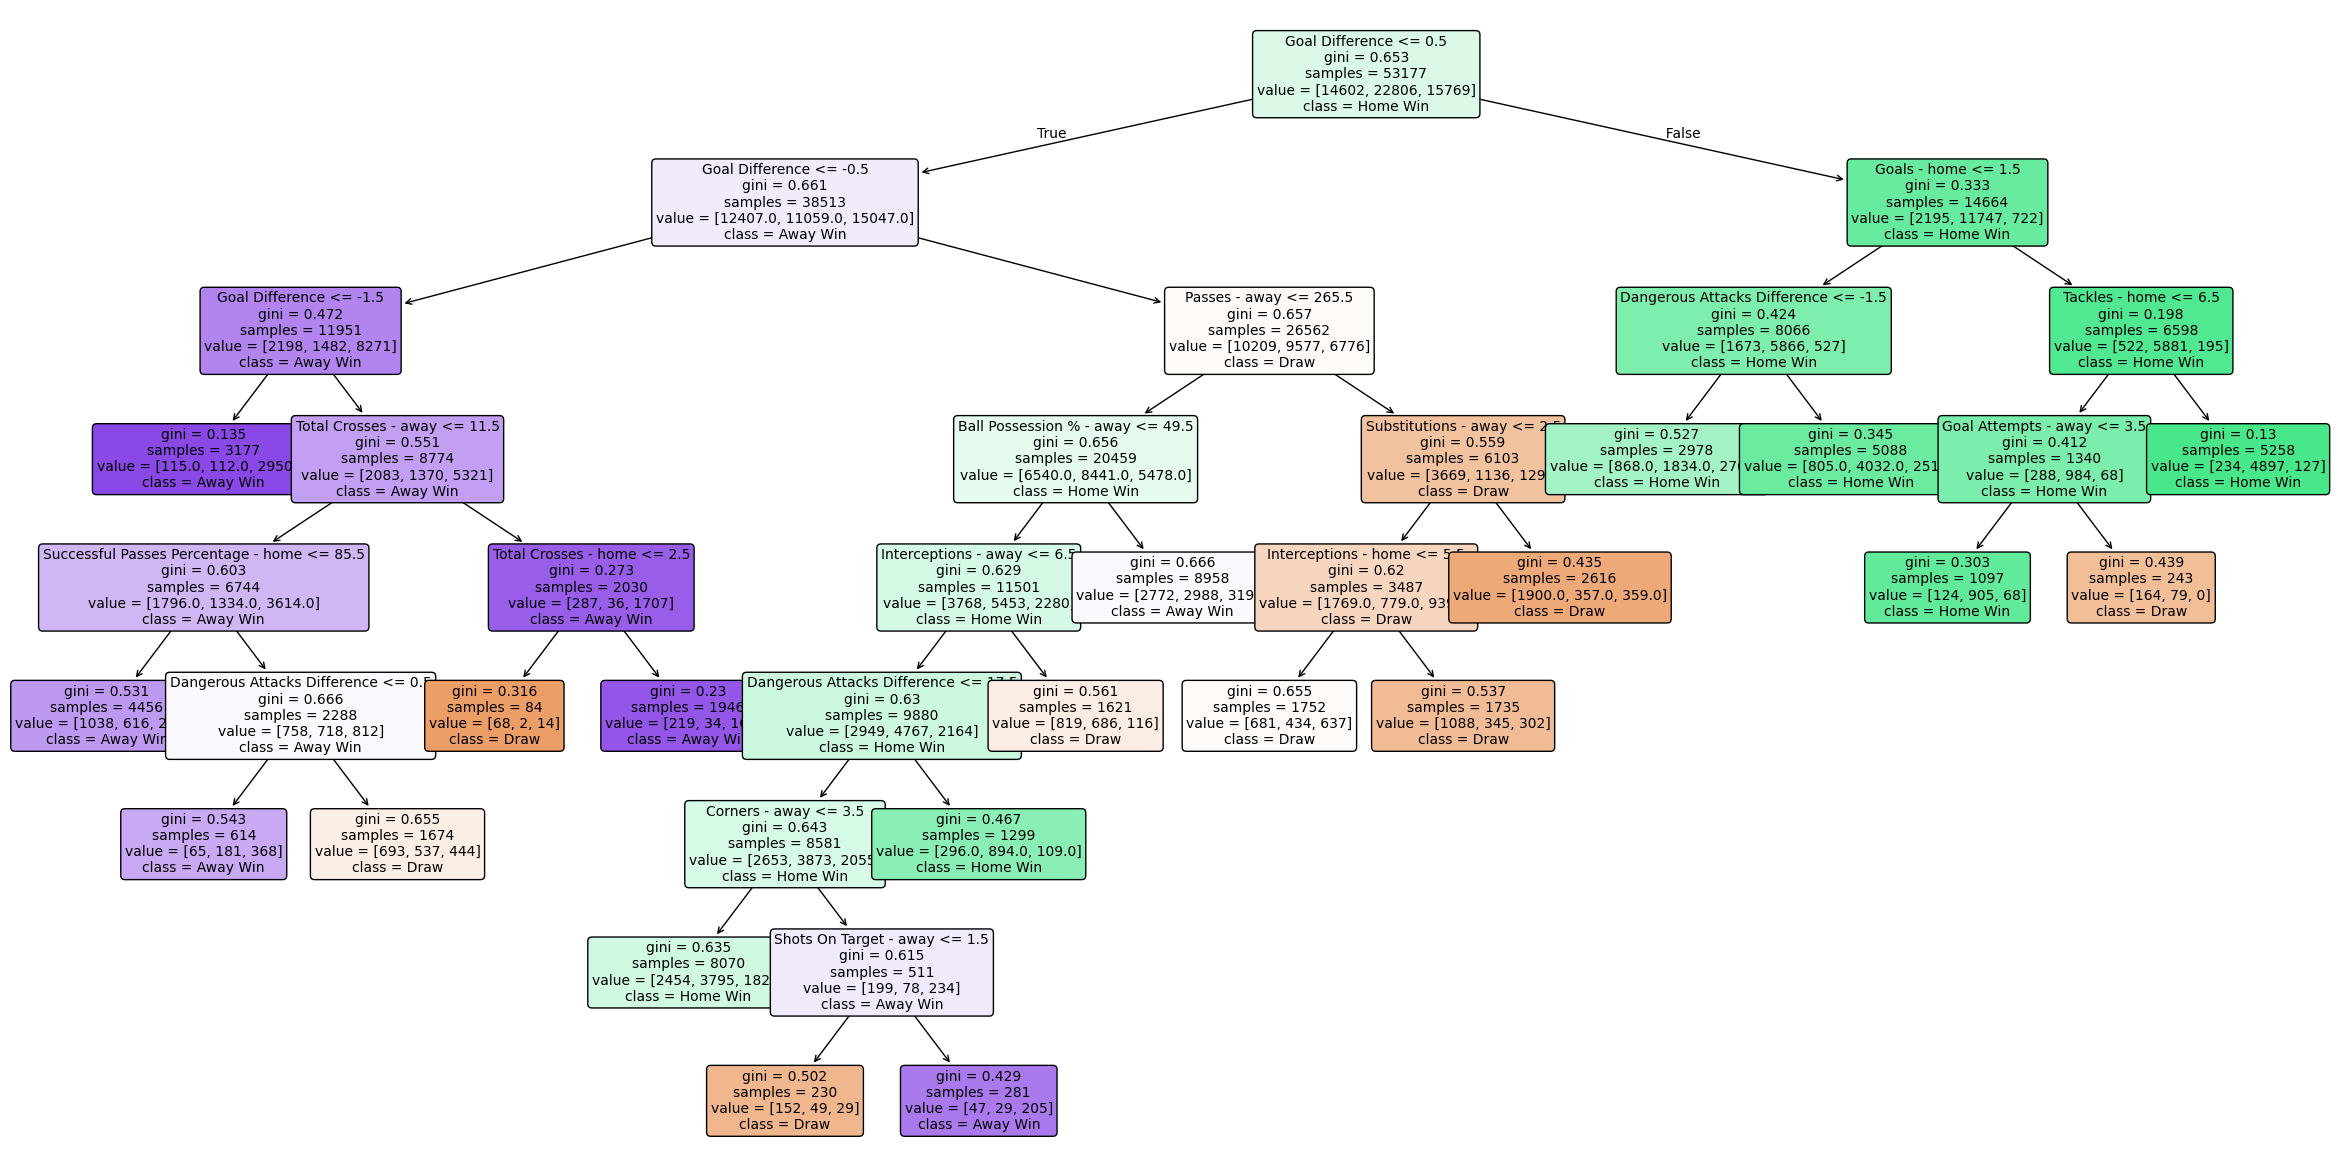

In [469]:
plt.figure(figsize=(30, 15))  

plot_tree(
    classifier,
    feature_names=feature_df.columns,
    class_names=["Draw","Home Win", "Away Win",],
    filled=True,
    fontsize=10,  
    rounded=True)

plt.show()

In [470]:
predict_probs = classifier.predict_proba(feature_df)

predicted_prob_df = pd.DataFrame(
    predict_probs, 
    columns=["Pred{Draw}", "Pred{Home Win}", "Pred{Away Win}"])

df_odds = df[["X", "1", "2"]].copy()
prob_df = 1 / df_odds
prob_df.columns = ["Pr{Draw}", "Pr{Home Win}", "Pr{Away Win}"]
normalized_prob_df = prob_df.div(prob_df.sum(axis=1), axis=0)

compare_df = pd.concat([normalized_prob_df.reset_index(drop=True), predicted_prob_df.reset_index(drop=True)], axis=1)

compare_df["Diff{Draw}"] = compare_df["Pred{Draw}"] - compare_df["Pr{Draw}"]
compare_df["Diff{Home Win}"] = compare_df["Pred{Home Win}"] - compare_df["Pr{Home Win}"]
compare_df["Diff{Away Win}"] = compare_df["Pred{Away Win}"] - compare_df["Pr{Away Win}"]

compare_df

,Pr{Draw},Pr{Home Win},Pr{Away Win},Pred{Draw},Pred{Home Win},Pred{Away Win},Diff{Draw},Diff{Home Win},Diff{Away Win}
0,0.143310,0.763538,0.093152,0.304089,0.470260,0.225651,0.160779,-0.293278,0.132499
1,0.154762,0.773810,0.071429,0.227868,0.688222,0.083911,0.073106,-0.085588,0.012482
2,0.154762,0.773810,0.071429,0.227868,0.688222,0.083911,0.073106,-0.085588,0.012482
3,0.154762,0.773810,0.071429,0.227868,0.688222,0.083911,0.073106,-0.085588,0.012482
4,0.156250,0.781250,0.062500,0.227868,0.688222,0.083911,0.071618,-0.093028,0.021411
...,...,...,...,...,...,...,...,...,...
53172,0.124938,0.867625,0.007437,0.291471,0.615850,0.092680,0.166533,-0.251776,0.085243
53173,0.086805,0.909390,0.003804,0.291471,0.615850,0.092680,0.204665,-0.293541,0.088875
53174,0.086723,0.908531,0.004746,0.291471,0.615850,0.092680,0.204747,-0.292681,0.087934
53175,0.073871,0.923393,0.002736,0.291471,0.615850,0.092680,0.217599,-0.307543,0.089944


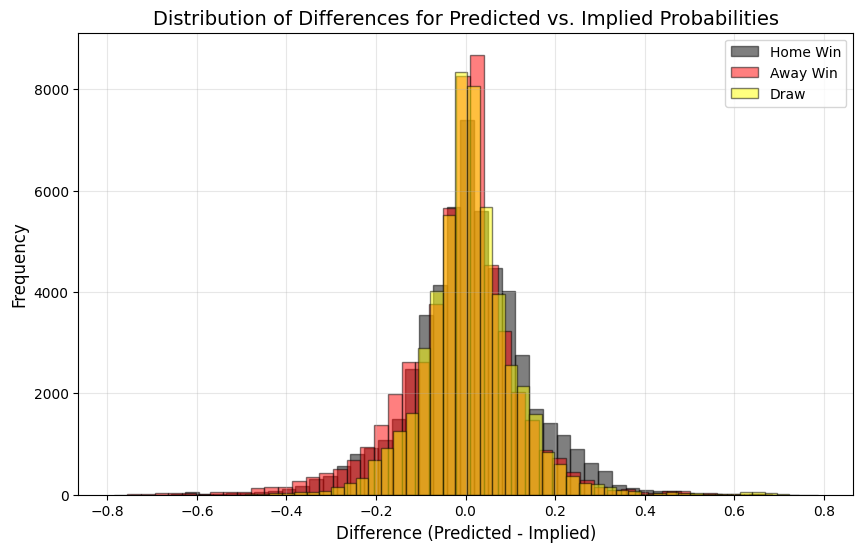

In [471]:
plt.figure(figsize=(10, 6))

compare_df["Diff{Home Win}"].hist(bins=50, alpha=0.5, color='black', edgecolor='black', label="Home Win")
compare_df["Diff{Away Win}"].hist(bins=50, alpha=0.5, color='red', edgecolor='black', label="Away Win")
compare_df["Diff{Draw}"].hist(bins=50, alpha=0.5, color='yellow', edgecolor='black', label="Draw")

plt.title("Distribution of Differences for Predicted vs. Implied Probabilities", fontsize=14)
plt.xlabel("Difference (Predicted - Implied)", fontsize=12)
plt.ylabel("Frequency", fontsize=12)

plt.grid(alpha=0.3)
plt.legend(loc = "upper right")
plt.show()

### Conclusion <a name="conclusion"></a>